# Preprocessing

It is considered best practice to do some preprocessing on your data, as it can sometimes improve the results of your machine learning model.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('data/chl_regression_tutorial.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

features = ['rho_443_a', 'rho_492_a', 'rho_560_a', 'rho_665_a', 'rho_704_a', 'rho_740_a', 'rho_783_a', 'rho_865_a']
target = 'CHL'

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

## Preprocessing your features

A simple way to do this is using scikit-learn's standard scaler, which removes the mean and scales to unit variance: `z = (x - u) / s`

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

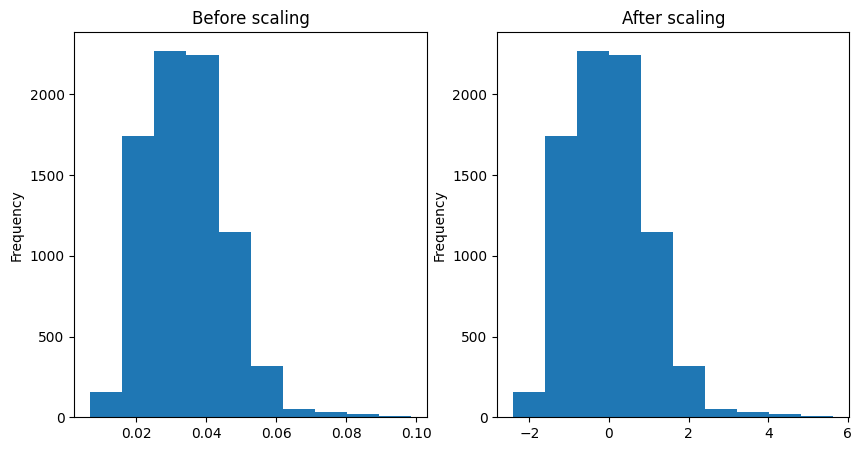

In [23]:
# plot distribution of X_train['rho_443_a] and X_train_scaled[:, 0] next to each other
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
X_train['rho_443_a'].plot(kind='hist')
plt.title('Before scaling')
plt.subplot(1, 2, 2)
pd.Series(X_train_scaled[:, 0]).plot(kind='hist')
plt.title('After scaling')
plt.show()

First, we evaluate the model without scaling.

In [32]:
model = LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'MSE before scaling the data: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 4.527730
MSE before scaling the data: 3.090875641325473


Next, we evaluate with scaling. Note that we also need to apply the previously fit scaler object to the test data in order to work.

In [33]:
model = LGBMRegressor()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f'MSE after scaling the data: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 4.527730
MSE after scaling the data: 3.0883706751400695


As you can see, only a very small difference is achieved here by scaling the data. Scaling does not always necessary improve your model, but sometimes it does.

## Transforming your target variable

Not only your features can undergo preprocessing, this can also be done on your target variable. This can be done similarly to transforming your training data, but you can also wrap this transformation in your model object using TransformedTargetRegressor.

In [16]:
# import transformed target regressor
from sklearn.compose import TransformedTargetRegressor
import numpy as np

We define our model, the function we want to apply to our target (in this case log 10) and the inverse function.

In [21]:
def inverse_log10(x: pd.Series) -> pd.Series:
    """Inverse of the log10 function. Used in the target transformer,
    as a function with only one argument is needed.

    Args:
        x (pd.Series): Input to be inverse transformed.

    Returns:
        pd.Series: Inverse transformed input.
    """
    return np.power(10, x)

model = LGBMRegressor()
wrapped_model = TransformedTargetRegressor(regressor=model, func=np.log10, inverse_func=inverse_log10)

The resulting model is trained and applied as usual.

In [22]:
wrapped_model.fit(X_train, y_train)

y_pred = wrapped_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'MSE with log-transformed target: {mse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 0.487548
MSE with log-transformed target: 3.1194888268529675
